In [1]:
import torch
import matplotlib.pyplot as plt
import EIANN.utils as ut
import EIANN.plot as pt
import EIANN._network as nt


from tqdm.autonotebook import tqdm
import numpy as np
import matplotlib.gridspec as gs
%load_ext autoreload
%autoreload 2

pt.update_plot_defaults()

/Users/aaronmil/src/EIANN/EIANN/utils/data_utils.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Vanilla BP MNIST

In [2]:
train_dataloader, train_sub_dataloader, val_dataloader, test_dataloader, data_generator = ut.get_MNIST_dataloaders(sub_dataloader_size=20_000)

In [3]:
# Build network
network_name = "EIANN_1_hidden_mnist_vanBP"
config_path = f"../network_config/MNIST_templates/{network_name}.yaml"
saved_network_path = f"saved_networks/{network_name}.pkl"
bp = ut.build_EIANN_from_config(config_path, network_seed=66049)

# Train network
data_seed = 257
data_generator.manual_seed(data_seed)
bp.train(train_sub_dataloader, 
                test_dataloader, 
                epochs=1,
                val_interval=(0,-1,500),
                store_history=True, 
                store_params=True,
                status_bar=True)
ut.save_network(bp, path=saved_network_path)

bp_network = ut.load_network(saved_network_path)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/20000 [00:00<?, ?it/s]

Saved network to 'saved_networks/EIANN_1_hidden_mnist_vanBP.pkl'
Loading network from 'saved_networks/EIANN_1_hidden_mnist_vanBP.pkl'
Network successfully loaded from 'saved_networks/EIANN_1_hidden_mnist_vanBP.pkl'


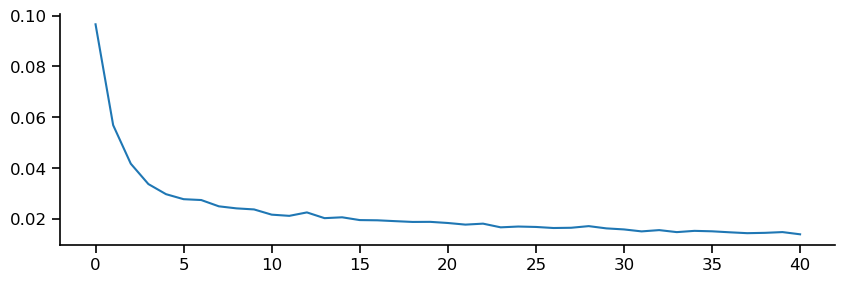

In [4]:
plt.plot(bp_network.val_loss_history)

Batch accuracy = 94.48999786376953%


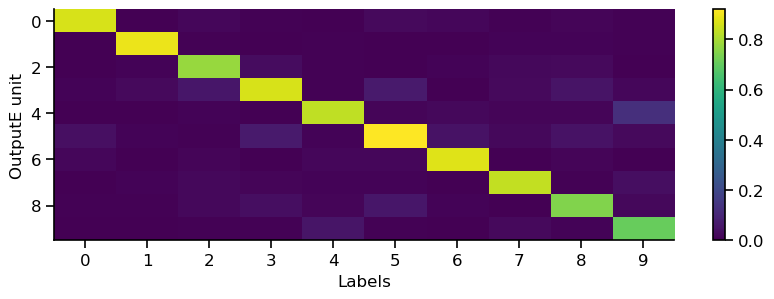

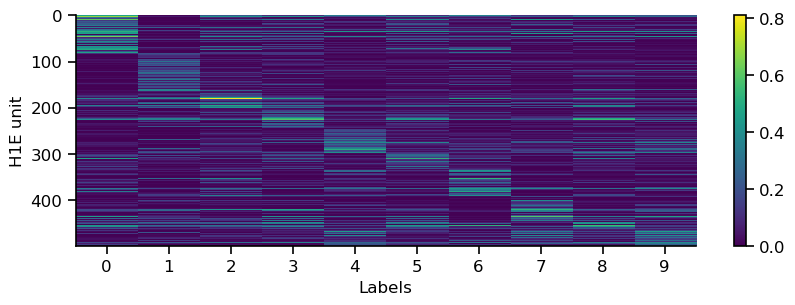

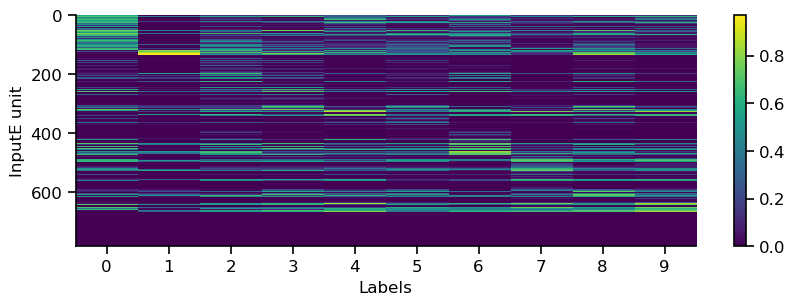

In [6]:
pt.plot_batch_accuracy(bp_network, test_dataloader, population='all')

### Spiral Networks

In [51]:
spiral_train_dataloader, spiral_val_dataloader, spiral_test_dataloader, spiral_data_generator = ut.get_spiral_dataloaders(N=2000)

# Build network
network_name = "EIANN_2_hidden_spiral_dend_EI_contrast_fixed_bias_AM_20241003"
config_path = f"../network_config/spiral/{network_name}.yaml"
saved_network_path = f"../saved_networks/{network_name}.pkl"
spiral_bp = ut.build_EIANN_from_config(config_path, network_seed=0)

# Train network
data_seed = 1
spiral_data_generator.manual_seed(data_seed)
spiral_bp.train(spiral_train_dataloader, 
                spiral_test_dataloader, 
                epochs=1,
                val_interval=(0,-1,500),
                store_history=True, 
                store_params=True,
                status_bar=True)
# ut.save_network(spiral_bp, path=saved_network_path)
# spiral_bp_net = ut.load_network(saved_network_path)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/5600 [00:00<?, ?it/s]

Batch accuracy = 81.83000183105469%


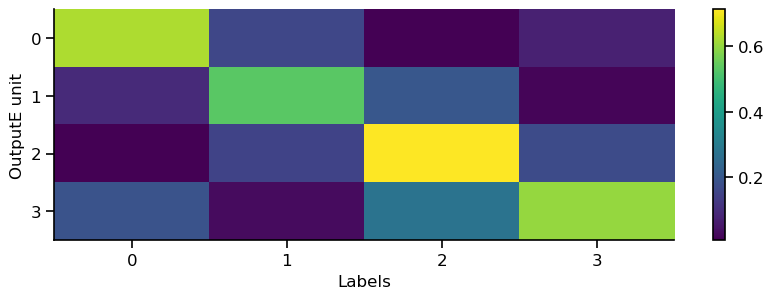

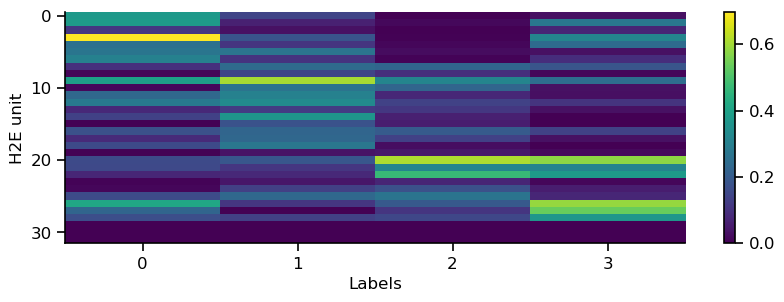

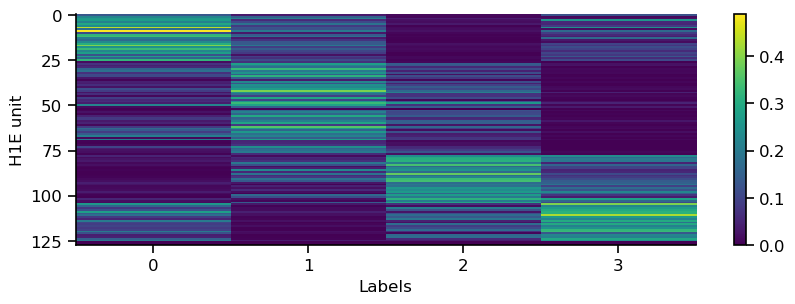

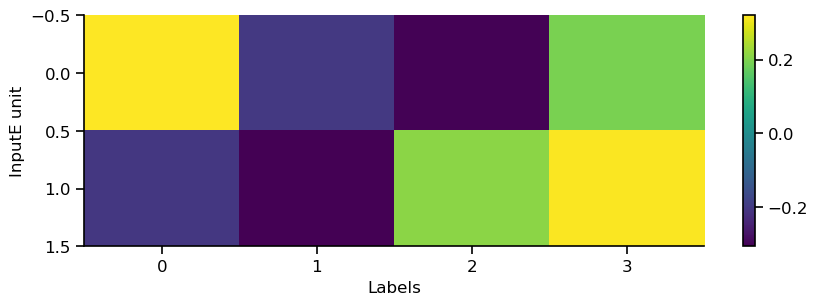

In [52]:
pt.plot_batch_accuracy(spiral_bp, spiral_test_dataloader, population='all')

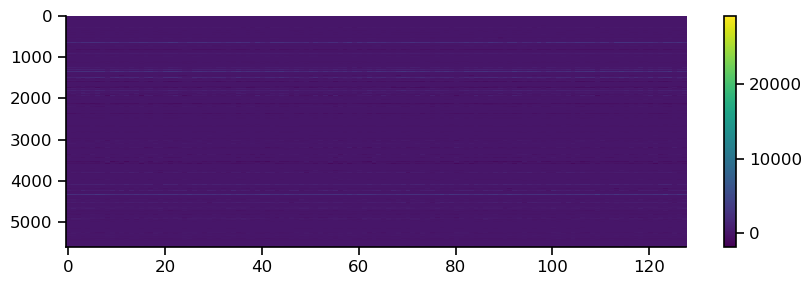

In [24]:
plt.figure()
plt.imshow(spiral_bp.H1.E.forward_dendritic_state_history, aspect='auto', interpolation='none')
plt.colorbar()

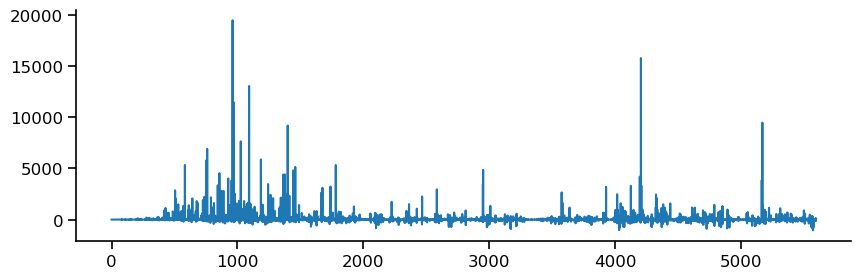

In [25]:
plt.figure()
plt.plot(torch.mean(spiral_bp.H1.E.forward_dendritic_state_history, dim=1))

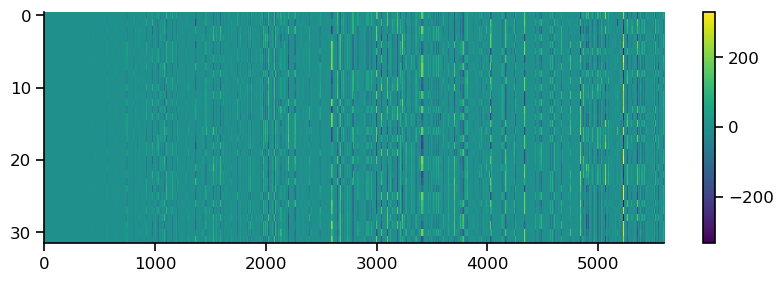

In [26]:
plt.figure()
# plt.plot(torch.mean(torch.abs(spiral_bp.H2.E.forward_dendritic_state_history), dim=1))
plt.imshow(spiral_bp.H2.E.forward_dendritic_state_history.T, aspect='auto', interpolation='none')
plt.colorbar()

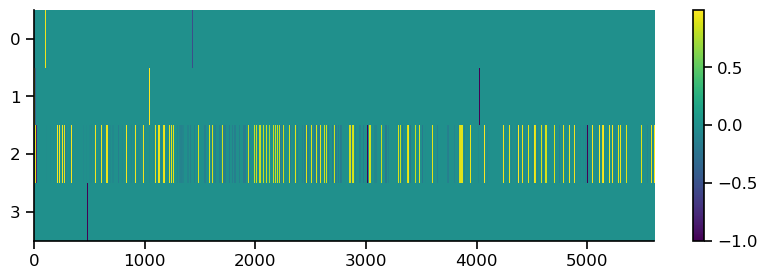

In [29]:
plt.figure()
# plt.plot(torch.mean(spiral_bp.Output.E.plateau_history, dim=1))
plt.imshow(spiral_bp.Output.E.plateau_history.T, aspect='auto', interpolation='none')
# plt.xlim(0, 1000)
plt.colorbar()

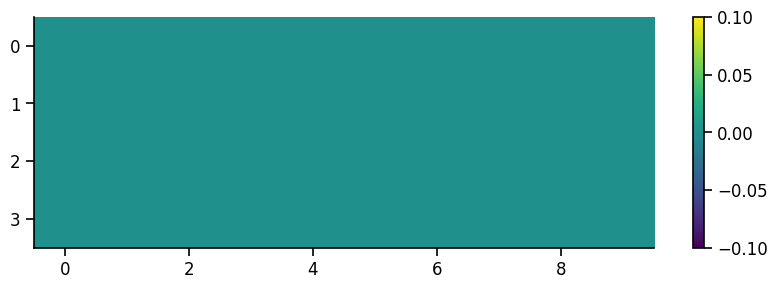

In [24]:
plt.figure()
# plt.plot(torch.mean(spiral_bp.Output.E.plateau_history, dim=1))
plt.imshow(spiral_bp.Output.E.activity_history[-10:].T, aspect='auto', interpolation='none')
# plt.xlim(0, 10)
plt.colorbar()

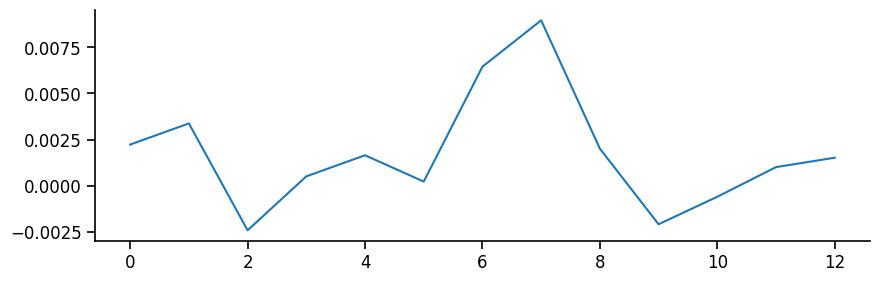

In [66]:
plt.figure()
plt.plot(torch.mean(spiral_bp.H2.E.H2.E.weight_history, dim=(1,2)))

In [59]:
spiral_bp.H2.E.attribute_history_dict.keys()

dict_keys(['activity', 'forward_dendritic_state', 'plateau', 'backward_dendritic_state', 'backward_activity'])

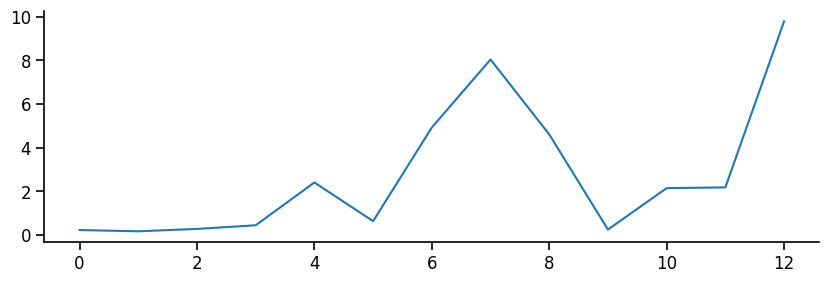

In [9]:
plt.plot(spiral_bp.val_loss_history)

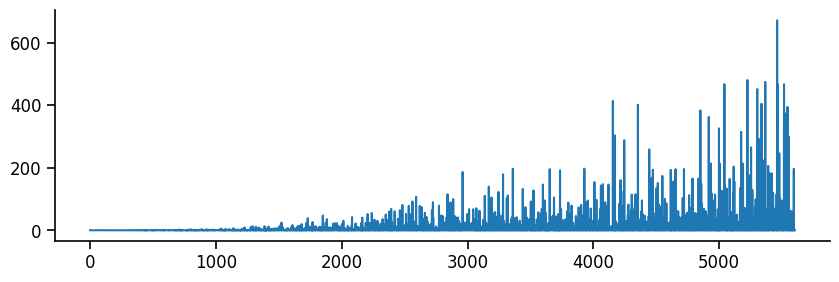

In [10]:
plt.plot(spiral_bp.loss_history)

In [11]:
index, data, label = next(iter(spiral_test_dataloader))

print(spiral_bp.forward(data))
print(label)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]])


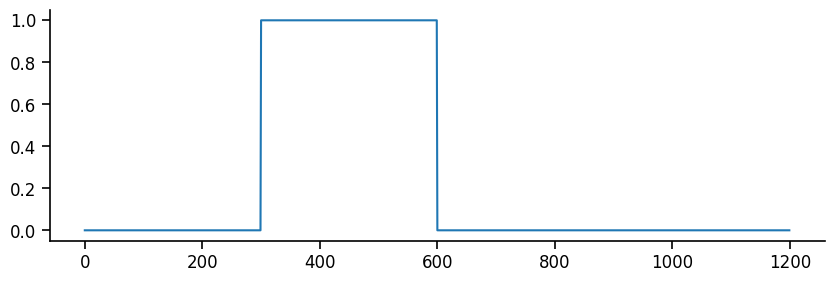

In [12]:
plt.plot(label[:,1])